<a href="https://colab.research.google.com/github/tanoManzo/mimic_trajectories/blob/dev/MIMIC_TRAJECTORY_embeddings_02_collect_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 7.4 MB/s eta 0:00:00


In [2]:
import torch 
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


load nursing notes subject-caregiver-chartdate

In [4]:
import pandas as pd
import numpy as np
notes_path = "/content/drive/MyDrive/NIH/Data/"
notes_name = "NOTES_NURSING_TRAJECTORIES_01.csv"
df_notes = pd.read_csv(notes_path+notes_name)
df_notes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 531675 entries, 0 to 531674
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   ROW_ID      531675 non-null  int64 
 1   SUBJECT_ID  531675 non-null  int64 
 2   CGID        531675 non-null  int64 
 3   CHARTDATE   531675 non-null  object
 4   TEXT        531675 non-null  object
dtypes: int64(3), object(2)
memory usage: 20.3+ MB


lead from nicu (used in the previous work)

In [5]:
notes_name = "NOTES_NURSING_NEONATOLOGY.csv" # has young patient with matching notes
df_notes_neonat = pd.read_csv(notes_path+notes_name)
df_notes_neonat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1177 entries, 0 to 1176
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   SUBJECT_ID      1177 non-null   int64 
 1   CGID            1177 non-null   int64 
 2   ROW_ID          1177 non-null   int64 
 3   TEXT            1177 non-null   object
 4   text_num_words  1177 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 46.1+ KB


# **Data Preprocessing**

get from nicu

In [6]:
df_notes_nicu = pd.merge(df_notes,df_notes_neonat[['ROW_ID']], how='inner', on=['ROW_ID'])
df_notes_nicu

,ROW_ID,SUBJECT_ID,CGID,CHARTDATE,TEXT
0,2080962,32392,17603,2199-12-05,NPN DAYS\nRECEIVED [**Doctor Last Name **] AT ...
1,1816458,9864,17001,2196-06-07,NPN 7a-7p\n#1: Blood cultures remain negative ...
2,1768864,6559,17001,2170-11-19,NPN 7a-1330\nReceived [**Doctor Last Name 846*...
3,1983076,22263,14274,2147-04-25,Admission Note\nBaby [**Name (NI) 4**] ([**Kno...
4,1698844,1456,14160,2190-11-28,Nursing Progress Note\n\n1 alteration in respi...
...,...,...,...,...,...
820,1983078,22263,20104,2147-04-25,Procedure Note: UVC reposition\nUVC pulled bac...
821,2044561,27671,20104,2192-08-31,Procedure Note: Umbilical Arterial Catheter Re...
822,1969117,21063,20104,2115-05-29,NNP On-call\nX-ray shows UAC [**Company 1001**...
823,1711001,2402,20104,2148-01-18,Procedure Note: UVC adjustment\nUVC pulled bac...


## Data exploration 

check number of notes per patient/subject

number of notes: min=1, max=15, mean=2.0024271844660193,  median=1.0


<Axes: xlabel='TEXT'>

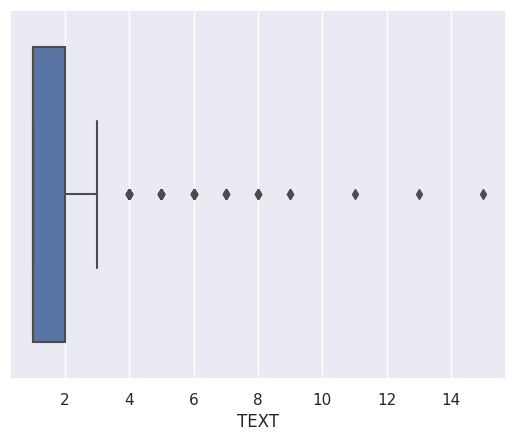

In [7]:
import seaborn as sns
sns.set()


gb_notes = df_notes_nicu.groupby(['CGID','SUBJECT_ID'])
num_notes = gb_notes['TEXT'].count()

print(f'number of notes: min={num_notes.min()}, max={num_notes.max()}, mean={num_notes.mean()},  median={num_notes.median()}')
sns.boxplot(x=num_notes)

check number of caregiver/subject that have between 4 and 15 notes

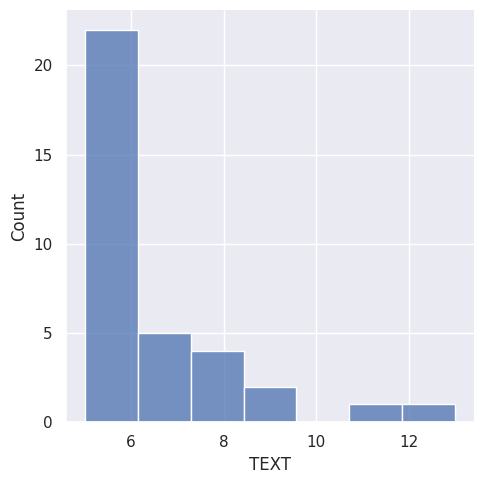

In [8]:
sns.displot(num_notes[((num_notes>4) & (num_notes<15))])

take only caregivers/patients' ids that have 6 notes (to start)

In [9]:
ids = num_notes[num_notes==6].index
ids

MultiIndex([(14274,  7919),
            (15393, 18093),
            (15658,  7919),
            (15930,  9864),
            (17986, 18093),
            (18311,  4412),
            (18706,  4412),
            (18869,  1456),
            (20104,  4412)],
           names=['CGID', 'SUBJECT_ID'])

## Input data

In [10]:
# ids = num_notes[num_notes==6].index
# cgid, subid = ids[0] has 1 change in sentiment
# cgid, subid = ids[7] has 1 change in sentiment
# cgid, subid = ids[8] has 1 change in sentiment
cgid, subid = ids[0]
df_notes_nicu_selected = df_notes_nicu[(df_notes_nicu['CGID'] == cgid) & (df_notes_nicu['SUBJECT_ID'] == subid)].sort_values(by=['CHARTDATE'])
df_notes_nicu_selected

,ROW_ID,SUBJECT_ID,CGID,CHARTDATE,TEXT
314,1791424,7919,14274,2141-08-30,Nursing Progress Note\n\n\n#2-O/A- Received i...
275,1791489,7919,14274,2141-09-07,Nursing Progress Note\n\n\n#2-O/A- Received i...
395,1791495,7919,14274,2141-09-08,Nursing Progress Note\n\n\n#2-O/A- Received i...
444,1791522,7919,14274,2141-09-11,Nursing Progress Note\n\n\n#2-O/A- Received in...
423,1791531,7919,14274,2141-09-12,Nursing Progress Note\n\n\n#2-O/A- Received i...
584,1791584,7919,14274,2141-09-19,Nursing NICU Note\nReceived infant intubated o...


input for embeddings

In [11]:
sentences = df_notes_nicu_selected['TEXT'].tolist()

## Embeddings 

In [12]:
model_ckpt = "sentence-transformers/all-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)

In [13]:
encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")
with torch.no_grad():
  model_output = model(**encoded_input)

for k,v in encoded_input.items():
  print(k)
  print(v.numpy())

input_ids
[[  101  8329  5082 ... 19555  1998   102]
 [  101  8329  5082 ...  1008  1008   102]
 [  101  8329  5082 ...     0     0     0]
 [  101  8329  5082 ...     0     0     0]
 [  101  8329  5082 ...     0     0     0]
 [  101  8329 27969 ...     0     0     0]]
token_type_ids
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
attention_mask
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]


In [14]:
token_embeddings = model_output.last_hidden_state
print(token_embeddings.size())
print('num of sentences, num of tokens, embed dim')
print('ONE EMBEDDING VECTOR PER TOKEN')

torch.Size([6, 512, 384])
num of sentences, num of tokens, embed dim
ONE EMBEDDING VECTOR PER TOKEN


In [15]:
def mean_pooling(model_output, attention_mask):
  token_embeddings = model_output.last_hidden_state
  input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
  return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

# Perform pooling
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

# Normalize embeddings
sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)

print("Sentence embeddings:")
print(sentence_embeddings)
print('ONE EMBEDDING VECTOR PER SENTENCE')

Sentence embeddings:
tensor([[-0.0092, -0.0697, -0.0138,  ..., -0.0400, -0.0141, -0.0025],
        [-0.0358, -0.0599, -0.0638,  ..., -0.0381,  0.0260,  0.0131],
        [-0.0212, -0.0772, -0.0093,  ..., -0.0783, -0.0111,  0.0117],
        [-0.0668, -0.0713, -0.0428,  ..., -0.0403,  0.0199,  0.0261],
        [-0.0122, -0.0605, -0.0389,  ..., -0.0582,  0.0542,  0.0316],
        [-0.0727,  0.0193, -0.0625,  ...,  0.0036,  0.0692, -0.0128]])
ONE EMBEDDING VECTOR PER SENTENCE


In [16]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

sentence_embeddings_np = sentence_embeddings.detach().numpy()

scores = np.zeros((sentence_embeddings_np.shape[0],sentence_embeddings_np.shape[0]))
dist = []
for idx in range(sentence_embeddings_np.shape[0]):
  scores[idx,:] = cosine_similarity([sentence_embeddings_np[idx]],sentence_embeddings_np)[0]            
  if idx < len(sentence_embeddings_np)-1:
    dist.append(scores[idx,idx+1])

scores     

array([[1.00000024, 0.87584394, 0.86426395, 0.84937769, 0.85996926,
        0.46558288],
       [0.87584394, 1.        , 0.87632763, 0.91837597, 0.92241257,
        0.47584435],
       [0.86426395, 0.87632763, 1.        , 0.87629044, 0.89986753,
        0.47219339],
       [0.84937769, 0.91837597, 0.87629044, 1.        , 0.94125414,
        0.54149175],
       [0.85996926, 0.92241251, 0.89986765, 0.94125426, 1.        ,
        0.47044104],
       [0.46558294, 0.47584438, 0.47219336, 0.54149175, 0.47044104,
        1.        ]])

<Axes: >

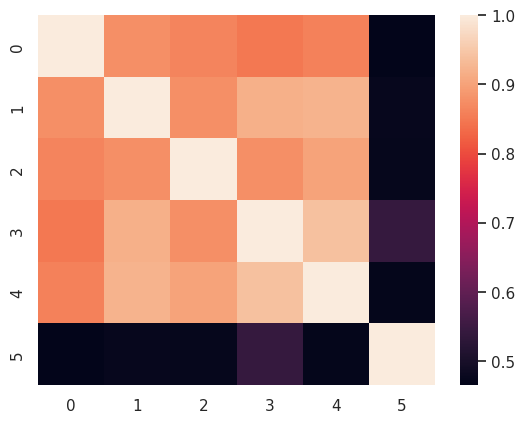

In [17]:
import seaborn as sns
sns.set()

sns.heatmap(scores)

<Axes: >

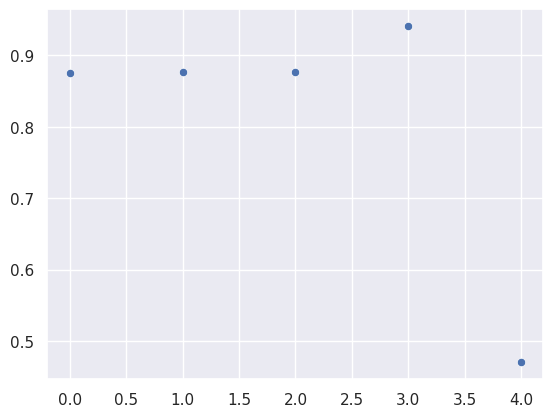

In [18]:
sns.scatterplot(dist)

Attitude 

In [19]:
from transformers import AutoModelForSequenceClassification
# model name from huggingface.co/model name_id:model_name
models_name = {
  'roberta':'tanoManzo/roberta-attitude',
  'distilbert':'tanoManzo/distilbert-attitude',
  'minilm':'tanoManzo/minilm-attitude',
  'bloom':'tanoManzo/bloom-attitude'
}

# load tokenizer and model 
tokenizers = [AutoTokenizer.from_pretrained(model_name) for model_name in models_name.values()]
models= [AutoModelForSequenceClassification.from_pretrained(model_name) for model_name in models_name.values()]

In [20]:
# select dataframe split
df_to_infer = df_notes_nicu_selected

# parameters to set 
total_notes = len(df_to_infer)
batch_size = 1
iterations = int(len(df_to_infer)/batch_size)


In [29]:
def create_sentiment_labels():
  l_scores = {k:[] for k in models_name.keys()} # dict Model: labels 
  l_labels = {k:[] for k in models_name.keys()} # dict Model: scoress
  for iter in range(iterations):
    

    idx_start = batch_size*iter     # first window sentence idx in the dataframe
    idx_end = batch_size*(iter+1)   # last window sentence idx in the dataframe
    
    # get row sentences for batch
    sentences = list(df_to_infer['TEXT'].iloc[idx_start:idx_end].values)
  
    for (index, (key, value)) in enumerate(models_name.items()):
      
      # tokenized input for the model 
      tokenizer = tokenizers[index]
      batch = tokenizer(sentences, # list of sentence 
                      padding=True, # add if short 
                      truncation=True, # remove if long 
                      max_length=512, # sent length
                      return_tensors="pt" # to return pytorch tensor (NO for TF)
                      )
    
    
      
      model = models[index]
      with torch.no_grad():
        outputs = model(**batch)
        predictions = F.softmax(outputs.logits, dim=1)
        label_ids = torch.argmax(predictions, dim=1)

        labels = [model.config.id2label[label_id] for label_id in label_ids.tolist()]
        scores = [round(float(predictions[idx][label_id].item()),4) for idx, label_id in enumerate(label_ids.tolist())]
        l_labels[key].extend(labels)
        l_scores[key].extend(scores)
create_sentiment_labels()

In [30]:
l_labels

{'roberta': ['Overall Neutral Note',
  'Overall Neutral Note',
  'Overall Neutral Note',
  'Overall Neutral Note',
  'Overall Neutral Note',
  'Overall Negative Note'],
 'distilbert': ['Overall Neutral Note',
  'Overall Neutral Note',
  'Overall Neutral Note',
  'Overall Neutral Note',
  'Overall Neutral Note',
  'Overall Negative Note'],
 'minilm': ['Overall Neutral Note',
  'Overall Neutral Note',
  'Overall Neutral Note',
  'Overall Neutral Note',
  'Overall Neutral Note',
  'Overall Negative Note'],
 'bloom': ['Overall Neutral Note',
  'Overall Neutral Note',
  'Overall Neutral Note',
  'Overall Neutral Note',
  'Overall Neutral Note',
  'Overall Neutral Note']}

# **Add labels to graph**

In [23]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.ticker import MaxNLocator

<ipython-input-24-92d161f0cb53>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_ticks)


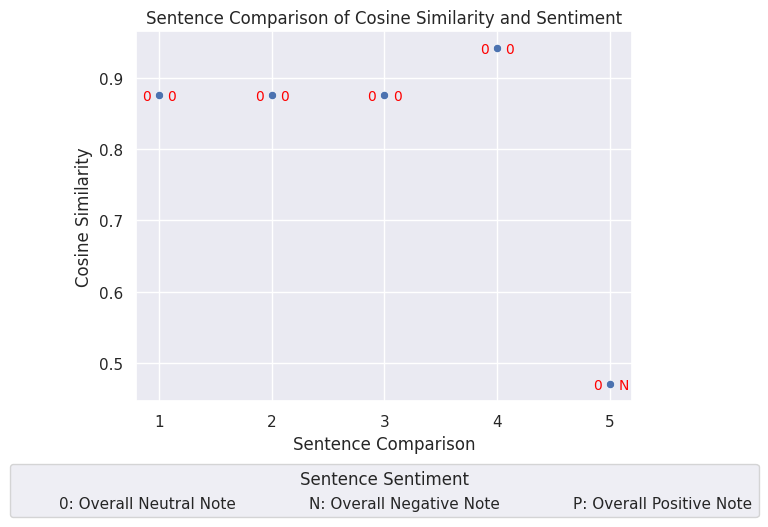

In [24]:
sns.scatterplot(dist)
model_labels = l_labels['roberta']
labels_dict = {'Overall Neutral Note': '0', 'Overall Negative Note': 'N', 'Overall Positive Note': 'P'}
graph_labels = [labels_dict[label] for label in model_labels]

# Add sentiment next to points
for index, row in enumerate(dist):

  x_position = index - 0.15
  x2_position = index + 0.075
  y_position = dist[index] - 0.0075
  plt.text(x_position, y_position, graph_labels[index], fontsize=10, color='red')
  plt.text(x2_position, y_position, graph_labels[index+1], fontsize=10, color='red')

# Title and x/y axes
plt.title("Sentence Comparison of Cosine Similarity and Sentiment")
plt.xlabel("Sentence Comparison")
plt.ylabel("Cosine Similarity")

# X-axis tick marks
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
new_ticks = [str(i) for i in range(len(graph_labels))]
ax.set_xticklabels(new_ticks)

# Legend
legend_handles = [Rectangle((0, 0), 0, 0, alpha=0, label=f"{short_label}: {original_label}") 
                  for original_label, short_label in labels_dict.items()]
#legend_handles = [Text(0, 0, label=f"{short_label}: {original_label}") for original_label, short_label in labels_dict.items()]

# legend to right of graph
#plt.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1, 0.5), title='Sentiment')

# legend under graph
plt.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=len(labels_dict), title='Sentence Sentiment')

plt.show()

<ipython-input-25-08c9145dc2d6>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_ticks)


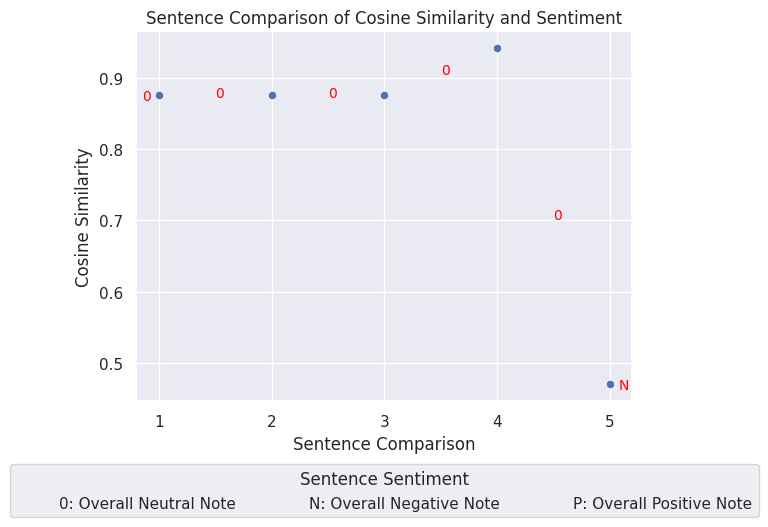

In [25]:
sns.scatterplot(dist)
model_labels = l_labels['roberta']
labels_dict = {'Overall Neutral Note': '0', 'Overall Negative Note': 'N', 'Overall Positive Note': 'P'}
graph_labels = [labels_dict[label] for label in model_labels]

# Add sentiment next to points
plt.text(-0.15, dist[0]-.0075, graph_labels[0], fontsize=10, color='red')
for index, row in enumerate(dist):
  if index == 0:
    continue
  x_position = index - 0.5
  x2_position = index + 0.075
  y_position = (dist[index] + dist[index-1] - 0.0075)/2
  plt.text(x_position, y_position, graph_labels[index], fontsize=10, color='red')
plt.text(len(dist)-1+0.075, dist[len(dist)-1]-0.0075, graph_labels[len(dist)], fontsize=10, color='red')

# Title and x/y axes
plt.title("Sentence Comparison of Cosine Similarity and Sentiment")
plt.xlabel("Sentence Comparison")
plt.ylabel("Cosine Similarity")

# X-axis tick marks
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
new_ticks = [str(i) for i in range(len(graph_labels))]
ax.set_xticklabels(new_ticks)

# Legend
legend_handles = [Rectangle((0, 0), 0, 0, alpha=0, label=f"{short_label}: {original_label}") 
                  for original_label, short_label in labels_dict.items()]
#legend_handles = [Text(0, 0, label=f"{short_label}: {original_label}") for original_label, short_label in labels_dict.items()]

# legend to right of graph
#plt.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1, 0.5), title='Sentiment')

# legend under graph
plt.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=len(labels_dict), title='Sentence Sentiment')

plt.show()

## Clustering 

In [26]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

In [27]:
clustering_model = KMeans(n_clusters=3)
clustering_model.fit(sentence_embeddings_np)
cluster_assignment = clustering_model.labels_
print(cluster_assignment)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[1 2 1 2 2 0]


In [28]:
clustered_sentences = {}
for sentence_id, cluster_id in enumerate(cluster_assignment):
    if cluster_id not in clustered_sentences:
        clustered_sentences[cluster_id] = []

    clustered_sentences[cluster_id].append(sentences[sentence_id])
clustered_sentences

IndexError: ignored

In [ ]:
from scipy.spatial.distance import cdist

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 6)
X = sentence_embeddings_np 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
  
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'cosine'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
  
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

In [ ]:
import matplotlib.pyplot as plt
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()